In [ ]:
! pip install paperswithcode-client

     |████████████████████████████████| 8.6 MB 60.2 MB/s 
     |████████████████████████████████| 41 kB 601 kB/s 
     |████████████████████████████████| 62 kB 740 kB/s 
     |████████████████████████████████| 503 kB 50.1 MB/s 
     |████████████████████████████████| 195 kB 69.6 MB/s 
     |████████████████████████████████| 48 kB 5.4 MB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
     |████████████████████████████████| 296 kB 47.5 MB/s 
     |████████████████████████████████| 41 kB 551 kB/s 
     |████████████████████████████████| 41 kB 521 kB/s 
     |████████████████████████████████| 41 kB 308 kB/s 
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled pytz-2022.1
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 1.5.1
    Uninstalling tzlocal-1.5.1:
      

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 15.1 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 54.8 MB/s 
     |████████████████████████████████| 596 kB 62.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import json
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from paperswithcode import PapersWithCodeClient
client = PapersWithCodeClient()
dataset_page = client.paper_list()

In [ ]:
QASPER_PATH = "/content/drive/MyDrive/SEW.NLP/qasper-train-dev-v0.3/"
qasper_relative_paths = ["qasper-train-v0.3.json", "qasper-dev-v0.3.json", "qasper-test-v0.3.json"]

data = []
for sp in qasper_relative_paths:
    f = open(QASPER_PATH + sp)
    data.append(json.load(f))

In [ ]:
data[0]['1601.00901']["qas"]

[{'answers': [{'annotation_id': '2ad8a8c4827f8617a9f38d243b56a2adb3518ba5',
    'answer': {'evidence': ['In this paper, we propose a novel approach to joint learning of ontology and semantic parsing, which is designed for homogeneous collections of text, where each fact is usually stated only once, therefore we cannot rely on data redundancy. Our approach is text-driven, semi-automatic and based on grammar induction. It is presented in Figure 1 .The input is a seed ontology together with text annotated with concepts from the seed ontology. The result of the process is an ontology with extended instances, classes, taxonomic and non-taxonomic relations, and a semantic parser, which transform basic units of text, i.e sentences, into semantic trees. Compared to trees that structure sentences based on syntactic information, nodes of semantic trees contain semantic classes, like location, profession, color, etc. Our approach does not rely on any syntactic analysis of text, like part-of-speec

In [ ]:
cleaned_qasper = {"question":[], "answer":[], "context":[], "start_index":[], "end_index":[], "sections":[]} # structure of the data we want to reach

for split in data:
    for paper in split.keys():
        paper_data = split[paper]
        paper_context = paper_data["abstract"]
        paper_sections = {"abstract": len(paper_context)}
        for section in paper_data["full_text"]:
            section_name = section["section_name"].lower() if section["section_name"] != None else " "
            for paragraph in section["paragraphs"]:
                paper_context += (" " + paragraph)
                paper_sections[section_name] = len(paper_context)

        for question in paper_data["qas"]:
            for answer in question["answers"]:
                if answer["answer"]["unanswerable"]:
                    cleaned_qasper["answer"].append(" ")
                    cleaned_qasper["question"].append(question["question"])
                    cleaned_qasper["context"].append(paper_context)
                    cleaned_qasper["start_index"].append(-1)
                    cleaned_qasper["end_index"].append(-1)
                    cleaned_qasper["sections"].append(paper_sections)
                    continue

                for answer_span in answer["answer"]["extractive_spans"]:
                    start_index = paper_context.find(answer_span)
                    end_index = start_index + len(answer_span) - 1
                    
                    cleaned_qasper["answer"].append(answer_span)
                    cleaned_qasper["question"].append(question["question"])
                    cleaned_qasper["context"].append(paper_context)
                    cleaned_qasper["start_index"].append(start_index)
                    cleaned_qasper["end_index"].append(end_index)
                    cleaned_qasper["sections"].append(paper_sections)

qasper_df = pd.DataFrame(cleaned_qasper)

In [ ]:
def find_answer_section(row):
    if row["start_index"] == -1:
        return "N/A"
        
    start_idx = row["start_index"]
    for k, val in row["sections"].items():
        if start_idx < val:
            return k

In [ ]:
qasper_df["section_answer"] = qasper_df.apply(find_answer_section, axis=1)

In [ ]:
qasper_df

,question,answer,context,start_index,end_index,sections,section_answer
0,What is the seed lexicon?,seed lexicon consists of positive and negative...,Recognizing affective events that trigger posi...,5820,5876,"{'abstract': 638, 'introduction': 3088, 'relat...",proposed method ::: discourse relation-based e...
1,What are labels available in dataset for super...,negative,Recognizing affective events that trigger posi...,54,61,"{'abstract': 638, 'introduction': 3088, 'relat...",abstract
2,What are labels available in dataset for super...,positive,Recognizing affective events that trigger posi...,42,49,"{'abstract': 638, 'introduction': 3088, 'relat...",abstract
3,How large is raw corpus used for training?,100 million sentences,Recognizing affective events that trigger posi...,9267,9287,"{'abstract': 638, 'introduction': 3088, 'relat...","experiments ::: dataset ::: al, ca, and co"
4,How is the annotation experiment evaluated?,confusion matrices of labels between annotators,Most approaches to emotion analysis regarding ...,24177,24223,"{'abstract': 1212, '': 1218, ' ::: ': 1226, ' ...",expert annotation ::: agreement
...,...,...,...,...,...,...,...
8979,Which three variants of cross-validation are e...,"xval(9:1, strat, rand) - 10-fold, stratified, ...",Social media are becoming an increasingly impo...,-1,75,"{'abstract': 3081, 'introduction': 7394, 'rela...",N/A
8980,In what way are sentiment classes ordered?,time-ordered,Social media are becoming an increasingly impo...,479,490,"{'abstract': 3081, 'introduction': 7394, 'rela...",abstract
8981,In what way are sentiment classes ordered?,negative,Social media are becoming an increasingly impo...,3705,3712,"{'abstract': 3081, 'introduction': 7394, 'rela...",introduction
8982,In what way are sentiment classes ordered?,neutral,Social media are becoming an increasingly impo...,3715,3721,"{'abstract': 3081, 'introduction': 7394, 'rela...",introduction


In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("ixa-ehu/SciBERT-SQuAD-QuAC")
model = AutoModelForQuestionAnswering.from_pretrained("ixa-ehu/SciBERT-SQuAD-QuAC")

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

In [ ]:
def narrow_context(row):
    context = row["context"]
    start_index = max(row["start_index"] - 2000, 0) 
    end_index = max(row["end_index"] + 2000, 4000)
    end_index = min(end_index, len(context)-1)
    return context[start_index:end_index]

In [ ]:
qasper_df["narrowed_context"] = qasper_df.apply(narrow_context, axis=1)

In [ ]:
def find_index(row):
    answer = row["answer"]
    start_index = row["narrowed_context"].find(answer) if row["start_index"] != -1 else -1
    end_index = start_index + len(answer) - 1 if row["start_index"] != -1 else -1
    return start_index, end_index

In [ ]:
qasper_df["start-end"] = qasper_df.apply(find_index, axis=1)

In [ ]:
search_for = ["data", "feature", "variable", "result", "preprocessing", "labels", "baseline"]

filtered_questions = qasper_df.loc[qasper_df["question"].str.contains("|".join(search_for))].reset_index()

In [ ]:
filtered_questions

,index,question,answer,context,start_index,end_index,sections,section_answer,narrowed_context,start-end
0,1,What are labels available in dataset for super...,negative,Recognizing affective events that trigger posi...,54,61,"{'abstract': 638, 'introduction': 3088, 'relat...",abstract,Recognizing affective events that trigger posi...,"(54, 61)"
1,2,What are labels available in dataset for super...,positive,Recognizing affective events that trigger posi...,42,49,"{'abstract': 638, 'introduction': 3088, 'relat...",abstract,Recognizing affective events that trigger posi...,"(42, 49)"
2,7,Do they report results only on English data?,,A community's identity defines and shapes its ...,-1,-1,"{'abstract': 1444, 'introduction': 6675, 'a ty...",N/A,A community's identity defines and shapes its ...,"(-1, -1)"
3,12,What data is the language model pretrained on?,Chinese general corpus,Clinical text structuring is a critical and fu...,17901,17922,"{'abstract': 824, 'introduction': 4629, 'relat...",experimental studies ::: experimental settings,layer first to achieve a better contextualize...,"(2000, 2021)"
4,13,What data is the language model pretrained on?,,Clinical text structuring is a critical and fu...,-1,-1,"{'abstract': 824, 'introduction': 4629, 'relat...",N/A,Clinical text structuring is a critical and fu...,"(-1, -1)"
...,...,...,...,...,...,...,...,...,...,...
3382,8932,What are state-of-the-art models on this dataset?,BERT (IR upper bound),"We introduce the first open-domain dataset, ca...",7817,7837,"{'abstract': 774, 'introduction': 2388, 'relat...",models,"d other edits as needed to change the answer, ...","(2000, 2020)"
3383,8933,What are state-of-the-art models on this dataset?,BERT-PFT (no knowledge),"We introduce the first open-domain dataset, ca...",7916,7938,"{'abstract': 774, 'introduction': 2388, 'relat...",models,n causes (A) wetter land (B) drier land Q-flip...,"(2000, 2022)"
3384,8934,What are state-of-the-art models on this dataset?,BERT-PFT (IR),"We introduce the first open-domain dataset, ca...",8175,8187,"{'abstract': 774, 'introduction': 2388, 'relat...",models,"e $K_i$, potentially answerable by simply matc...","(2000, 2012)"
3385,8935,What are state-of-the-art models on this dataset?,BERT-PFT (IR),"We introduce the first open-domain dataset, ca...",8175,8187,"{'abstract': 774, 'introduction': 2388, 'relat...",models,"e $K_i$, potentially answerable by simply matc...","(2000, 2012)"


In [ ]:
qasper_df["section_answer"].value_counts()[:40]

N/A                                                              1073
introduction                                                     1062
abstract                                                          184
datasets                                                          161
experiments                                                       160
related work                                                      140
experimental setup                                                124
results                                                           120
dataset                                                           113
evaluation                                                         91
baselines                                                          88
data                                                               80
methodology                                                        79
experiments and results                                            75
conclusion          

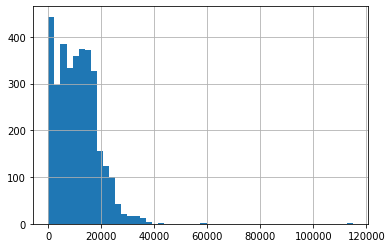

In [ ]:
filtered_questions["start_index"].hist(bins=50)

In [ ]:
filtered_questions[filtered_questions["start_index"] > 100000]

,index,question,answer,context,start_index,end_index,sections,section_answer,narrowed_context,start-end
996,2788,Which datasets are used in this work?,GENIA corpus,Events of various kinds are mentioned and disc...,114794,114805,"{'abstract': 769, 'introduction': 4933, 'event...",biomedical event extraction,meronymic relations by BIBREF190 . Granularit...,"(2000, 2011)"


In [ ]:
filtered_questions[filtered_questions["answer"].str.contains("Deep projective reader")]

,index,question,answer,context,start_index,end_index,sections,section_answer,narrowed_context,start-end
1347,3802,What baselines are presented?,Deep projective reader,Deep reading models for question-answering hav...,20283,20304,"{'abstract': 1472, 'introduction': 5688, 'mach...",models,n and three neural models. The first one is a ...,"(2000, 2021)"
1351,3806,What baselines are presented?,Deep projective reader,Deep reading models for question-answering hav...,20283,20304,"{'abstract': 1472, 'introduction': 5688, 'mach...",models,n and three neural models. The first one is a ...,"(2000, 2021)"


In [ ]:
filtered_questions[filtered_questions["narrowed_context"].str.contains("sentiment-specific embeddings")].tail(50)

,index,question,answer,context,start_index,end_index,sections,section_answer,narrowed_context,start-end
1536,4261,What baseline method is used?,"use the word2vec algorithm, create several uns...",Sentiments of words differ from one corpus to ...,5576,5750,"{'abstract': 1326, 'introduction': 4103, 'rela...",related work,o evaluated our novel embedding approaches on ...,"(2000, 2174)"
1541,4266,What word-based and dictionary-based feature a...,generate word embeddings specific to a domain,Sentiments of words differ from one corpus to ...,7309,7353,"{'abstract': 1326, 'introduction': 4103, 'rela...",methodology ::: corpus-based approach,a sentiment lexicon is induced preferring the...,"(2000, 2044)"


In [ ]:
filtered_questions.loc[1347, "narrowed_context"][2000:2022]

'Deep projective reader'

In [ ]:
tokenized = tokenizer(list(filtered_questions["question"]), list(filtered_questions["narrowed_context"]),
                      truncation="only_second",
                      padding="max_length",
                      max_length=512,
                      stride=256,
                      return_overflowing_tokens=True,
                      return_offsets_mapping=True)

In [ ]:
offsets_mapping = tokenized.pop("offset_mapping")

In [ ]:
for i, offset in enumerate(offsets_mapping):
    print(offset)
    break

[(0, 0), (0, 4), (5, 8), (9, 15), (16, 25), (26, 28), (29, 36), (37, 40), (41, 52), (52, 53), (0, 0), (0, 11), (12, 21), (22, 28), (29, 33), (34, 41), (42, 50), (51, 53), (54, 62), (63, 72), (73, 76), (77, 78), (79, 83), (84, 89), (90, 92), (93, 100), (101, 109), (110, 120), (121, 133), (134, 137), (138, 145), (146, 147), (148, 159), (160, 167), (168, 174), (175, 182), (183, 186), (187, 195), (196, 198), (199, 201), (202, 207), (208, 210), (211, 214), (215, 226), (227, 238), (239, 243), (244, 247), (248, 259), (260, 265), (265, 266), (267, 269), (270, 274), (275, 280), (280, 281), (282, 284), (285, 292), (293, 295), (296, 305), (306, 315), (316, 324), (325, 330), (331, 340), (341, 350), (350, 351), (352, 355), (356, 362), (363, 365), (366, 372), (373, 376), (377, 381), (382, 390), (391, 392), (393, 397), (398, 403), (404, 408), (409, 416), (417, 420), (421, 422), (423, 428), (429, 432), (433, 439), (439, 440), (441, 444), (445, 456), (457, 462), (463, 471), (472, 476), (477, 481), (482

In [ ]:
for i in range(len(tokenized["overflow_to_sample_mapping"])):
    if tokenized["overflow_to_sample_mapping"][i] == 1347:
        print(i) 

4093
4094
4095


In [ ]:
answers = qasper_df["answer"]
start_positions = []
end_positions = []

for i, offset in enumerate(offsets_mapping):
    sequence_ids = tokenized.sequence_ids(i)
    
    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    df_index = tokenized["overflow_to_sample_mapping"][i]
    start_char, end_char = filtered_questions.loc[df_index, "start-end"]

    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

In [ ]:
tokenized["start_positions"] = start_positions
tokenized["end_positions"] = end_positions

## Intro paper preprocessing:

In [ ]:
intro_papers_questions = pd.read_csv("/content/drive/MyDrive/SEW.NLP/intro_papers_questions.txt", sep="|", header=None, names=["dataset", "question", "answer"])

In [ ]:
intro_papers_data = {"dataset":[], "context":[], "sections":[]}
PATH = "/content/drive/MyDrive/SEW.NLP"
intro_papers_subpaths = ["/intro_papers_repo", "/additional_paperswithcode_papers"]

for sp in intro_papers_subpaths:
    for paper_name in os.listdir(PATH + sp):
        if paper_name.endswith(".json"):
            f = open(PATH + sp + "/" + paper_name)
            paper = json.load(f)
            context = paper["abstract"]

            section_end = {"abstract": len(context)}
            for sec_type in ["body_text", "back_matter"]:
                for sec in paper["pdf_parse"][sec_type]:
                    sec_name = sec["section"].lower()
                    if sec_name != "abstract":
                        context += sec["text"]
                        section_end[sec_name] = len(context)
            
            intro_papers_data["dataset"].append(paper_name[:-5])
            intro_papers_data["context"].append(context)
            intro_papers_data["sections"].append(section_end)

intro_papers_context = pd.DataFrame(intro_papers_data)                     

In [ ]:
intro_papers_context

,dataset,context,sections
0,Sudanese Twitter Dataset,Sundanese is the second-largest tribe in Indon...,"{'abstract': 879, 'i. introduction': 2928, 'ii..."
1,NATICUSdroid (Android Permissions) Dataset,The rapid growth of Android apps and its world...,"{'abstract': 1695, 'introduction': 7758, 'rela..."
2,CBT,We introduce a new test of how well language m...,"{'abstract': 1281, 'introduction': 4238, 'the ..."
3,SQuAD,We present the Stanford Question Answering Dat...,"{'abstract': 757, 'introduction': 1837, 'what ..."
4,GLUE,For natural language understanding (NLU) techn...,"{'abstract': 951, 'introduction': 7314, 'tasks..."
5,Penn Treebank,1 A distinction is sometimes made between a co...,"{'abstract': 326, 'introduction': 3194, 'a sim..."
6,Auction Verification,Verification techniques play an essential role...,"{'abstract': 1173, 'i. introduction a. motivat..."
7,Palmer penguins,Background: Sexual segregation in vertebrate f...,"{'abstract': 2147, 'introduction': 10165, 'eth..."
8,ImageNet,The explosion of image data on the Internet ha...,"{'abstract': 1379, 'introduction': 3854, 'prop..."
9,MIMIC-III,MIMIC-III ('Medical Information Mart for Inten...,"{'abstract': 580, 'background & summary': 2616..."


In [ ]:
intro_papers_df = pd.merge(intro_papers_context, intro_papers_questions, on="dataset", how="inner")

In [ ]:
intro_papers_df

,dataset,context,sections,question,answer
0,Sudanese Twitter Dataset,Sundanese is the second-largest tribe in Indon...,"{'abstract': 879, 'i. introduction': 2928, 'ii...",Was any preprocessing performed?,"The preprocessing includes case folding, stop..."
1,Sudanese Twitter Dataset,Sundanese is the second-largest tribe in Indon...,"{'abstract': 879, 'i. introduction': 2928, 'ii...",How was data collected?,We gathered dataset from Twitter API between ...
2,Sudanese Twitter Dataset,Sundanese is the second-largest tribe in Indon...,"{'abstract': 879, 'i. introduction': 2928, 'ii...",For what purpose was the dataset collected?,Sundanese is the second-largest tribe in Indo...
3,NATICUSdroid (Android Permissions) Dataset,The rapid growth of Android apps and its world...,"{'abstract': 1695, 'introduction': 7758, 'rela...",How was the dataset collected?,We analyze declared permissions in more than ...
4,NATICUSdroid (Android Permissions) Dataset,The rapid growth of Android apps and its world...,"{'abstract': 1695, 'introduction': 7758, 'rela...",For what purpose was the dataset created?,With the constantly changing Android environm...
...,...,...,...,...,...
58,MPII,Human pose estimation has made significant pro...,"{'abstract': 1239, 'introduction': 3218, 'rela...",What does the dataset represent?,In this paper we introduce a large dataset of...
59,Conceptual Captions,We present a new dataset of image caption anno...,"{'abstract': 674, 'introduction': 3862, 'relat...",Was any preprocessing performed?,The following steps are applied to achieve te...
60,DAVIS,"Over the years, datasets and benchmarks have p...","{'abstract': 1186, 'introduction': 4785, 'rela...",For what purpose was the data collected?,a standardized and widely adopted evaluation ...
61,DAVIS,"Over the years, datasets and benchmarks have p...","{'abstract': 1186, 'introduction': 4785, 'rela...",What does the dataset represent?,"The dataset, which will be made publicly avai..."


In [ ]:
intro_papers_df.loc[intro_papers_df["question"] == "What does the dataset represent?", "question"] = "What do the instances that comprise the dataset represent?"

for col in ["context", "question", "answer"]:
    intro_papers_df[col] = intro_papers_df[col].str.strip()
    intro_papers_df[col] = intro_papers_df[col].str.replace(r"\. ", r".")
    intro_papers_df[col] = intro_papers_df[col].str.replace(r" \,", r",")
    intro_papers_df[col] = intro_papers_df[col].str.replace(r" \.", r".")
    intro_papers_df[col] = intro_papers_df[col].str.replace(r"\.", r". ")
    intro_papers_df[col] = intro_papers_df[col].str.replace(r" \)", r")")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [ ]:
def find_start_end(row, return_end=True):
    answer = row["answer"]
    start_index = row["context"].find(answer)
    end_index = start_index + len(answer) - 1
    if return_end:
        return start_index, end_index
    else:
        return start_index

In [ ]:
intro_papers_df["start-end"] = intro_papers_df.apply(lambda r: find_start_end(r, True), axis=1)
intro_papers_df["start_index"] = intro_papers_df.apply(lambda r: find_start_end(r, False), axis=1)

In [ ]:
def find_answer_section(row):
    start_idx = row["start_index"]
    for k, val in row["sections"].items():
        if start_idx < val:
            return k

In [ ]:
intro_papers_df["answer_section"] = intro_papers_df.apply(find_answer_section, axis=1)
intro_papers_df["end_index"] = intro_papers_df.apply(lambda row: row["start_index"] + len(row["answer"]) - 1, axis=1)

In [ ]:
intro_papers_df[intro_papers_df["end_index"]]

,dataset,context,sections,question,answer,start-end,start_index,answer_section,end_index
0,Sudanese Twitter Dataset,Sundanese is the second-largest tribe in Indon...,"{'abstract': 879, 'i. introduction': 2928, 'ii...",Was any preprocessing performed?,"The preprocessing includes case folding, stopw...","(398, 619)",398,abstract,619
1,Sudanese Twitter Dataset,Sundanese is the second-largest tribe in Indon...,"{'abstract': 879, 'i. introduction': 2928, 'ii...",How was data collected?,We gathered dataset from Twitter API between J...,"(5384, 5478)",5384,• gathering and annotation,5478
2,Sudanese Twitter Dataset,Sundanese is the second-largest tribe in Indon...,"{'abstract': 879, 'i. introduction': 2928, 'ii...",For what purpose was the dataset collected?,Sundanese is the second-largest tribe in Indon...,"(0, 309)",0,abstract,309
3,NATICUSdroid (Android Permissions) Dataset,The rapid growth of Android apps and its world...,"{'abstract': 1695, 'introduction': 7758, 'rela...",How was the dataset collected?,We analyze declared permissions in more than 2...,"(1120, 1389)",1120,abstract,1389
4,NATICUSdroid (Android Permissions) Dataset,The rapid growth of Android apps and its world...,"{'abstract': 1695, 'introduction': 7758, 'rela...",For what purpose was the dataset created?,With the constantly changing Android environme...,"(6436, 6639)",6436,introduction,6639
...,...,...,...,...,...,...,...,...,...
58,MPII,Human pose estimation has made significant pro...,"{'abstract': 1239, 'introduction': 3218, 'rela...",What does the dataset represent?,In this paper we introduce a large dataset of ...,"(6565, 6749)",6565,dataset,6749
59,Conceptual Captions,We present a new dataset of image caption anno...,"{'abstract': 674, 'introduction': 3862, 'relat...",Was any preprocessing performed?,The following steps are applied to achieve tex...,"(10315, 10798)",10315,text transformation with hypernymization,10798
60,DAVIS,"Over the years, datasets and benchmarks have p...","{'abstract': 1186, 'introduction': 4785, 'rela...",For what purpose was the data collected?,a standardized and widely adopted evaluation m...,"(3373, 3585)",3373,introduction,3585
61,DAVIS,"Over the years, datasets and benchmarks have p...","{'abstract': 1186, 'introduction': 4785, 'rela...",What does the dataset represent?,"The dataset, which will be made publicly avail...","(3586, 3800)",3586,introduction,3800


In [ ]:
intro_papers_df[["context", "question", "answer", "start_index", "end_index"]].to_csv("/content/drive/MyDrive/SEW.NLP/intro_papers_df.csv")

In [ ]:
intro_papers_df["answer_section"].value_counts()

introduction                                                       16
abstract                                                           10
dataset                                                             3
acknowledgments                                                     3
iv. verification of smr auctions -dataset creation                  2
acknowledgement                                                     2
walmart dataset: we consider a public dataset made available by     2
acknowledgements                                                    2
conclusions                                                         2
ethics statement                                                    1
discussion                                                          1
feature selection                                                   1
dataset contents                                                    1
processing metadata                                                 1
sensor specification

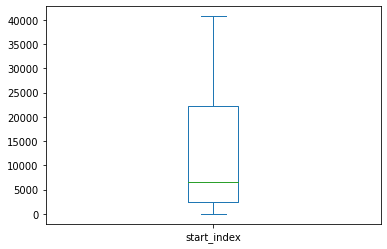

In [ ]:
intro_papers_df["start_index"].plot.box()